[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cadCAD-org/demos/blob/master/tutorials/robots_and_marbles/robot-marbles-part-6/robot-marbles-part-6.ipynb)


# cadCAD Tutorials: The Robot and the Marbles, part 6
In parts [1](../robot-marbles-part-1/robot-marbles-part-1.ipynb) and [2](../robot-marbles-part-2/robot-marbles-part-2.ipynb) we introduced the 'language' in which a system must be described in order for it to be interpretable by cadCAD and some of the basic concepts of the library:
* State Variables
* Timestep
* State Update Functions
* Partial State Update Blocks
* Simulation Configuration Parameters
* Policies

In [part 3](../robot-marbles-part-3/robot-marbles-part-3.ipynb) we covered how to describe the presence of asynchronous subsystems within the system being modeled in cadCAD. And [part 4](../robot-marbles-part-4/robot-marbles-part-4.ipynb) introduced Monte Carlo simulations.

In this notebook, we'll cover cadCAD's support for A/B testing, a useful feature when analyzing different design options for a system. Let's start by copying the base configuration with which we ended Part 4. Here's the description of that system:

__The robot and the marbles__  
* Picture a box (`box_A`) with ten marbles in it; an empty box (`box_B`) next to the first one; and __two__ robot arms capable of taking a marble from any one of the boxes and dropping it into the other one. 
* The robots are programmed to take one marble at a time from the box containing the largest number of marbles and drop it in the other box. They repeat that process until the boxes contain an equal number of marbles.
* The robots act __asynchronously__ and __non-deterministically__; at every timestep each robot acts with a probability P: 50% for robot 1 and 33.33% for robot 2.

In [1]:
%%capture
# Only run this cell if you need to install the libraries
# If running in google colab, this is needed.

!pip install cadcad matplotlib pandas numpy

In [58]:
# Import dependancies

# Data processing and plotting libraries
import pandas as pd
import numpy as np
from random import random as rand
import matplotlib.pyplot as plt
from pprint import pprint

# cadCAD specific libraries
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment
from cadCAD.engine import ExecutionContext, Executor,ExecutionMode
from cadCAD import configs

In [4]:
def p_robot_arm(params, substep, state_history, previous_state):
    
    # Parameters & variables
    box_a = previous_state['box_A']
    box_b = previous_state['box_B']
    
    # Logic
    if box_b > box_a:
        b_to_a = 1
    elif box_b < box_a:
        b_to_a = -1
    else:
        b_to_a = 0
    
    # Output
    return({'add_to_A': b_to_a, 'add_to_B': -b_to_a})

In [7]:
def s_box_A(params, substep, state_history,  previous_state, policy_input):
    # Parameters & variables
    box_A_current = previous_state['box_A']
    box_A_change = policy_input['add_to_A']
   
    # Logic
    box_A_new = box_A_current + box_A_change
    
    # Output
    return ('box_A', box_A_new)
    
def s_box_B(params, substep, state_history,  previous_state, policy_input):
    # Parameters & variables
    box_B_current = previous_state['box_B']
    box_B_change = policy_input['add_to_B']

    # Logic
    box_B_new = box_B_current + box_B_change
    
    # Output
    return ('box_B', box_B_new)

In [8]:
# We specify each of the robots logic in a Policy Function
robots_probabilities = [0.5,1/3] # Robot 1 acts with a 50% probability; Robot 2, 33.33%

def robot_arm_1(params, substep, state_history, previous_state):
    _robotId = 1
    if rand()<robots_probabilities[_robotId-1]: # draw a random number between 0 and 1; if it's smaller than the robot's parameter, it acts
        return p_robot_arm(params, substep, state_history, previous_state)
    else:
        return({'add_to_A': 0, 'add_to_B': 0}) 

def robot_arm_2(params, substep, state_history, previous_state):
    _robotId = 2
    if rand()<robots_probabilities[_robotId-1]: # draw a random number between 0 and 1; if it's smaller than the robot's parameter, it acts
        return p_robot_arm(params, substep, state_history, previous_state)
    else:
        return({'add_to_A': 0, 'add_to_B': 0})

In [12]:
partial_state_update_blocks = [
    { 
        'policies': { # The following policy functions will be evaluated and their returns will be passed to the state update functions
            'robot_arm_1': robot_arm_1,
            'robot_arm_2': robot_arm_2
        },
        'variables': { # The following state variables will be updated simultaneously
            'box_A': s_box_A,
            'box_B': s_box_B
        }
    }
]

In [16]:
initial_state = {
    'box_A': 10, # box_A starts out with 10 marbles in it
    'box_B': 0 # box_B starts out empty
}

In [39]:
MONTE_CARLO_RUNS = 50
SIMULATION_TIMESTEPS = 10

sim_config = config_sim(
    {
        'N': MONTE_CARLO_RUNS,
        'T': range(SIMULATION_TIMESTEPS),
        #'M': {} # This will be explained in later tutorials
    }
)

In [40]:
del configs[:]

experiment = Experiment()

experiment.append_configs(
    sim_configs=sim_config,
    initial_state=initial_state,
    partial_state_update_blocks=partial_state_update_blocks,
)

exec_context = ExecutionContext()
run = Executor(exec_context=exec_context, configs=configs)

(system_events, tensor_field, sessions) = run.execute()
df = pd.DataFrame(system_events)


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (10, 1, 50, 2)
Execution Method: local_simulations
SimIDs   : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
SubsetIDs: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Ns       : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
ExpIDs   : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [42]:
pprint(sim_config)
df.set_index(['simulation', 'run', 'timestep', 'substep'])

{'M': [{}],
 'N': 1,
 'T': range(0, 10),
 'run_id': 49,
 'simulation_id': 0,
 'subset_id': 0,
 'subset_window': deque([0, 0], maxlen=2)}


box_A  box_B  subset
simulation run timestep substep                      
0          1   0        0           10      0       0
               1        1            9      1       0
               2        1            9      1       0
               3        1            7      3       0
               4        1            7      3       0
...                                ...    ...     ...
           50  6        1            6      4       0
               7        1            5      5       0
               8        1            5      5       0
               9        1            5      5       0
               10       1            5      5       0

[550 rows x 3 columns]

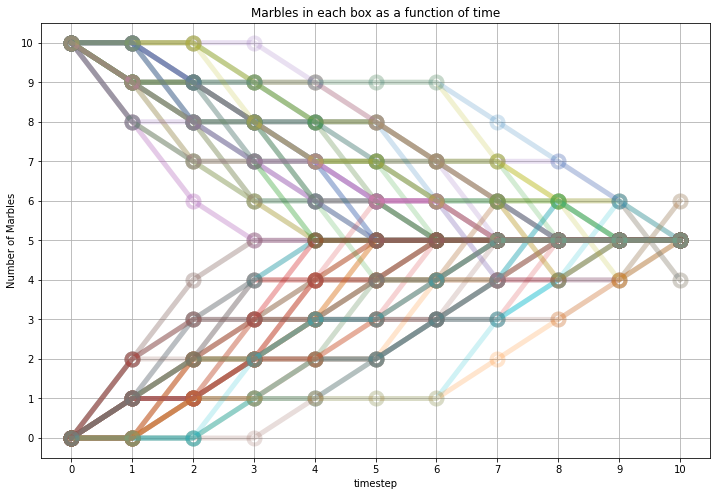

In [43]:
ax = None
for i in range(0,MONTE_CARLO_RUNS):
    ax =  df[df['run']==i+1].plot(x='timestep', y=['box_A','box_B'], marker='o', markersize=12,
                markeredgewidth=4, alpha=0.2, markerfacecolor='black',
                linewidth=5, figsize=(12,8),  title="Marbles in each box as a function of time", 
                ylabel='Number of Marbles', grid=True, fillstyle='none',  
                xticks=list(df['timestep'].drop_duplicates()), legend=None,
                yticks=list(range(1+(df['box_A']+df['box_B']).max())), ax=ax);

## A/B testing
In order to simulate two different versions of the same system, we create two `Configuration` objects to pass to the `Executor` instead of just one. For example, suppose we wanted to test the system under two different sets of __initial conditions__

In [46]:
initial_state_1 = {
    'box_A': 10, 
    'box_B': 0
}

initial_state_2 = {
    'box_A': 10,
    'box_B': 4 
}

Just like we did before, we package those initial conditions along with the partial state update blocks and the simulation parameters into `Configuration` objects

Add first configuration/paramater set:

In [54]:
del configs[:] # Clear all previous configs

MONTE_CARLO_RUNS = 30
SIMULATION_TIMESTEPS = 10

sim_config = config_sim(
    {
        'N': MONTE_CARLO_RUNS,
        'T': range(SIMULATION_TIMESTEPS),
        #'M': {} # This will be explained in later tutorials
    }
)

print("sim_config before being appended to the experiment:")
pprint(sim_config)

experiment.append_configs(
    sim_configs=sim_config,
    initial_state=initial_state_1, # Note the use off different initial states
    partial_state_update_blocks=partial_state_update_blocks,
)

print("\nsim_config after being appended to the experiment (note the mutation):")
pprint(sim_config)



sim_config before being appended to the experiment:
{'M': [{}], 'N': 30, 'T': range(0, 10)}

sim_config after being appended to the experiment (note the mutation):
{'M': [{}],
 'N': 1,
 'T': range(0, 10),
 'run_id': 29,
 'simulation_id': 0,
 'subset_id': 0,
 'subset_window': deque([0, 0], maxlen=2)}


Add the second parameter/configuration set

In [56]:
sim_config = config_sim(
    {
        'N': MONTE_CARLO_RUNS,
        'T': range(SIMULATION_TIMESTEPS),
        #'M': {} # This will be explained in later tutorials
    }
)

experiment.append_configs(
    sim_configs=sim_config,
    initial_state=initial_state_2, # Note the use off different initial states
    partial_state_update_blocks=partial_state_update_blocks,
)

And now we can execute the simulation of those two different versions of the system in parallel. In order to accomplish that, we use an `ExecutionContext` of mode `multi_proc`

In [65]:
exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.multi_proc) # For A/B testing we use multi_proc
run = Executor(exec_context=exec_context, configs=configs)

And we are ready to execute the simulation. The `execute()` method will return a list of tuples - the first element of those tuples correspond to the datapoints of each one of the versions of the system being simulated.

In [68]:
(system_events, tensor_field, sessions) = run.execute()
df = pd.DataFrame(system_events)

df.set_index(['simulation', 'run', 'timestep', 'substep'])


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: multi_proc
Configuration Count: 2
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (10, 1, 30, 2)
Execution Method: parallelize_simulations
Execution Mode: parallelized
Total execution time: 0.44s


box_A  box_B  subset
simulation run timestep substep                      
0          1   0        0           10      0       0
               1        1            9      1       0
               2        1            8      2       0
               3        1            6      4       0
               4        1            4      6       0
...                                ...    ...     ...
1          30  6        1            7      7       0
               7        1            7      7       0
               8        1            7      7       0
               9        1            7      7       0
               10       1            7      7       0

[660 rows x 3 columns]

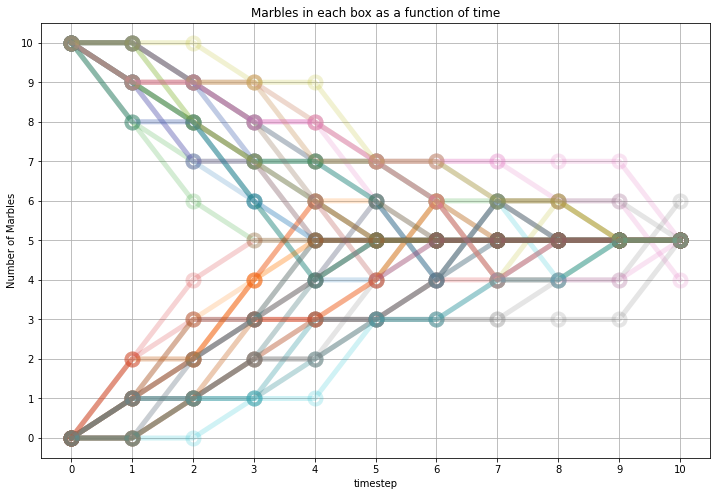

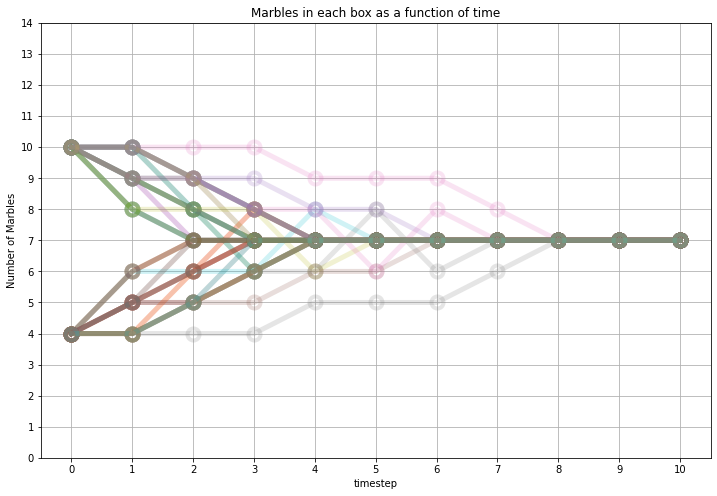

In [71]:
for simulation_id in range(2):
    ax = None
    for i in range(0,MONTE_CARLO_RUNS):
        ax =  df[(df['simulation']==simulation_id) & (df['run']==i+1)].plot(x='timestep', y=['box_A','box_B'], marker='o', markersize=12,
                    markeredgewidth=4, alpha=0.2, markerfacecolor='black',
                    linewidth=5, figsize=(12,8),  title="Marbles in each box as a function of time", 
                    ylabel='Number of Marbles', grid=True, fillstyle='none',  
                    xticks=list(df['timestep'].drop_duplicates()), legend=None,
                    yticks=list(range(1+(df[(df['simulation']==simulation_id)]['box_A']+df[(df['simulation']==simulation_id)]['box_B']).max())), ax=ax);

The same thing can be done for any sort of variation in the system being modeled: wheter it's the inclusion of a new state update function, a change in the order in which partial state update blocks get executed, or completely different policy and state update functions, all we need to do is create a different `Configuration` object for each one of the variations and pass those to the `Executor`.